# Modelo sobre deserción para trabajo de grado Maestría en Ciencia de Datos

El siguiente codigo se emplea para generar una red neuronal con pytorch, con variables categoricas, mediante el uso de embeddings. Como base, se utiliza el codigo de la pagina https://jretamales.github.io/2019-01-29-embeddings_101/, denominado "Embeddins con Pytorch" elaborado por Jorge Retamales en el 2019. Ademas se reutiliza codigos vistos en clases de Fundamentos de Analítica, con el profesor Javier Diaz, Universidad Icesi, para los procesos de optimización de parámetros y creación de funciones.

## Paquetes a instalar

In [ ]:
!pip install adjustText
!pip install prettytable
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Paquetes manejo de datos y otros
import pandas as pd
import numpy as np
import random

# Paquetes sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.manifold import TSNE

# Paquetes para graficar
%matplotlib inline
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Paquetes para redes neuronales con pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

# Paquete para modelo xgboost
import xgboost as xgb

# Paquete para medir tiempos de ejecución
import time

# Semilla

Se declara una semilla y se configura el entorno para ejecutar el codigo ya sea en CPU o GPU. Se recomienda su ejecución en un entorno con GPU debido a la disminución de tiempos de ejecución.

In [ ]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE = torch.device('cuda:0')
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [ ]:
def reset_seed():
    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reset_seed()

# Carga de datos desde Drive

Por reserva de información, se presenta solamente un vistado a la estructura de los datos, mas no se carga ni da enlace a los datos de entrenamiento del modelo. Tambien se resalta el proceso previo de pretratamiento de datos y analisis exploratorio en notebooks diferentes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd

# Leer el archivo parquet
df_mat_des = pd.read_parquet('/content/drive/MyDrive/DatosTesisMCD/matricula_desercion6.parquet')

In [ ]:
df_mat_des.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433713 entries, 0 to 232282
Data columns (total 67 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ANO_INF                   433713 non-null  object        
 1   MUN_CODIGO                433713 non-null  object        
 2   CODIGO_DANE               433713 non-null  object        
 3   DANE_ANTERIOR             433713 non-null  object        
 4   NOMBRE INSTITUCION        433713 non-null  object        
 5   CONS_SEDE                 433713 non-null  object        
 6   NOMBRE SEDE               433713 non-null  object        
 7   COMUNA                    433713 non-null  object        
 8   SECTOR                    433713 non-null  object        
 9   ZONA                      433713 non-null  object        
 10  TIPO_DOCUMENTO            433713 non-null  object        
 11  NRO_DOCUMENTO             433713 non-null  object        
 12  EX

# Ajustar variables

Debido a que el objetivo de análsis son los estudiantes de educación basica primaria, secundaria y media, de las 94 IEO a cargo de la Secretaría de Educación, congregaciones religiosas y Ministerio de Defensa, se realiza un filtro bajo estas condiciones.

In [ ]:
df_mat_des['DESERTOR'] = df_mat_des['DESERTOR'].replace({'SI': 1, 'NO': 0})

In [ ]:
## Sacar la matricula oficial cali por ieo, 94 IEO
df = df_mat_des[
    (df_mat_des.SECTOR.isin(['OFICIAL','SGP DEFENSA'])) &
    (df_mat_des['MATRICULA_CONTRATADA'] == 'N') &
    (df_mat_des.GRADO.isin(['1','2','3','4','5','6','7','8','9','10','11']))
    ]

print("La matricula oficial con",df['NOMBRE INSTITUCION'].nunique(),"es:",len(df))

La matricula oficial con 94 es: 284103


# Ajuste en el dataframe
Es necesario separar las variables categoricas de las continuas, dado que en el preprocesamiento a las categorias, se les aplicará codificación one hot encoding y embeddings y a las continuas una estandarización.

In [ ]:
# Variables continuas
contin_cols = ['EDAD', 'GRADO']

# Convertimos a punto flotante las continuas
for col in contin_cols:
    df[col] = df[col].astype(float)

N_CONT = len(contin_cols)
N_CONT

<ipython-input-34-4b8ea3b0d05d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)


2

Realziamos una prueba chi cuadrado, apra ver la relación de variables categoricas con la deserción, y así limitar el mdoeloa  als varibles más significativas.

In [ ]:
from scipy.stats import chi2_contingency

# Lista de variables categóricas
var_cuali_chi = df_mat_des[['ZONA', 'NIVEL_EDUCATIVO', 'GENERO', 'CLASI_ETNIA','VICTIMA', 'PROVIENE_OTR_MUN', 
                                    'TIPO_JORNADA', 'REPITENTE', 'NUEVO', 'DISCAPACIDAD',
                                    'SIT_ACAD_ANO_ANT', 'CON_ALUM_ANO_ANT', 'ZON_ALU', 
                                    'CAB_FAMILIA', 'APOYO_ACADEMICO_ESPECIAL', 'SRPA',  
                                    'CAP_EXC', 'BEN_MAD_FLIA', 'MUNI_RESIDENCIA', 'NAC_MUN', 'COMUNA',
                                    'TIPO_DISCAPACIDAD','PAIS_ABREV','ESTRATO']]

# Lista de resultados
resultados = []

# Iterar sobre cada variable categórica y aplicar el test de chi-cuadrado
for var in var_cuali_chi:
    # Crear tabla de contingencia entre la variable y DESERCION
    contingency_table = pd.crosstab(df_mat_des[var], df_mat_des["DESERTOR"])
    
    # Aplicar test de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Agregar resultados a la lista
    resultados.append({"Variable": var, "Chi-cuadrado": round(chi2, 2), "Valor p": round(p, 4)})

# Convertir lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados)

# Definir nivel de significancia
nivel_significancia = 0.05

# Agregar columna de significancia
resultados_df["Significancia"] = ["SI" if p < nivel_significancia else "NO" for p in resultados_df["Valor p"]]

# Mostrar resultados
print(resultados_df)


                    Variable  Chi-cuadrado  Valor p Significancia
0                       ZONA          0.02   0.8753            NO
1            NIVEL_EDUCATIVO       3151.29   0.0000            SI
2                     GENERO        218.40   0.0000            SI
3                CLASI_ETNIA         25.52   0.0003            SI
4                    VICTIMA         21.08   0.0000            SI
5           PROVIENE_OTR_MUN         12.46   0.0004            SI
6               TIPO_JORNADA       2907.50   0.0000            SI
7                  REPITENTE       2528.53   0.0000            SI
8                      NUEVO        289.08   0.0000            SI
9               DISCAPACIDAD          0.01   0.9246            NO
10          SIT_ACAD_ANO_ANT       4226.60   0.0000            SI
11          CON_ALUM_ANO_ANT        888.96   0.0000            SI
12                   ZON_ALU         12.50   0.0004            SI
13               CAB_FAMILIA         11.00   0.0009            SI
14  APOYO_

Variables categoricas con un valor p menos al nivel de significacia del 5%.

In [ ]:
categ_cols = [
    "NIVEL_EDUCATIVO",
    "GENERO",
    "CLASI_ETNIA",
    "VICTIMA",
    "PROVIENE_OTR_MUN",
    "TIPO_JORNADA",
    "REPITENTE",
    "NUEVO",
    "SIT_ACAD_ANO_ANT",
    "CON_ALUM_ANO_ANT",
    "ZON_ALU",
    "CAB_FAMILIA",
    "APOYO_ACADEMICO_ESPECIAL",
    "SRPA",
    "CAP_EXC",
    "BEN_MAD_FLIA",
    "NAC_MUN",
    "COMUNA",
    "PAIS_ABREV",
    "ESTRATO"
]
              
cat_counts = {}
for col in categ_cols:
    cat_counts[col] = df[col].value_counts()

cat_counts

# Codificación de las variables categoricas
A todas las variables categoricas tanto nominales como ordinales, se les crea un indice numérico, iniciando en 0 hasta la cantidad de categorias que comprenda. <br>

In [ ]:
# Recodificación columnas categóricas.

def encode_column(df, col):

    e = preprocessing.LabelEncoder() # instanciamos un modelo de sklearn para
    # etiquetar numericamente cada categoría.
    e = e.fit(df[col]) # Ajustamos a la data
    df[col] =e.transform(df[col]) # Recodificamos la columna del df con 
    # etiquetas númericas
    return e.classes_, e.transform(e.classes_)# tupla de categ originales y 
    # nuevas etiquetas

In [ ]:
categ_cols_mapping = {col: encode_column(df, col) for col in categ_cols}

# Juntar dataset variables categoricas recodificadas, continuas y variable desertor

In [ ]:
# Dataframe final
df = pd.concat([df[categ_cols + contin_cols], df['DESERTOR']], axis = 1)

In [ ]:
df.head()

,NIVEL_EDUCATIVO,GENERO,CLASI_ETNIA,VICTIMA,PROVIENE_OTR_MUN,TIPO_JORNADA,REPITENTE,NUEVO,SIT_ACAD_ANO_ANT,CON_ALUM_ANO_ANT,...,SRPA,CAP_EXC,BEN_MAD_FLIA,NAC_MUN,COMUNA,PAIS_ABREV,ESTRATO,EDAD,GRADO,DESERTOR
0,1,0,2,0,0,1,0,0,0,0,...,0,1,0,0,31,0,2,13.0,6.0,0
1,1,1,2,0,0,1,0,0,1,1,...,2,1,0,1,2,0,4,20.0,6.0,0
2,1,1,2,0,0,1,0,0,0,0,...,2,1,0,1,2,0,2,18.0,6.0,0
3,1,1,2,0,0,1,0,0,0,0,...,2,1,0,1,2,0,4,19.0,6.0,0
4,1,0,2,0,1,1,0,0,0,0,...,0,1,0,0,6,0,1,11.0,6.0,0


# Partición del conjunto de datos en (Train, Test y Val)
Se realiza partición entre datos de entrenamiento y prueba con una proporción 80/20.

In [ ]:
# Train vs testing

# Nuestro df tiene como última columna la variable dependiente. Por ello el -1.
# Además notar el uso de una semilla seudo-aleatoria, con el propósito 
# de replicabilidad en resultados. train_x, test_x, train_y, test_y, val_x, val_y

train_x, val_x, train_y, val_y = model_selection.train_test_split(df[df.columns[:-1]], 
                                                                    df[df.columns[-1]] , 
                                                                    test_size = 0.2,
                                                                    random_state = 42)

train_x, test_x, train_y, test_y = model_selection.train_test_split(train_x, 
                                                                    train_y, 
                                                                    test_size = 0.3,
                                                                    random_state = 42)

In [ ]:
pd.concat([train_y.value_counts() , test_y.value_counts() ], axis=1, keys=['train_y', 'test_y'])

,train_y,test_y
0,151399,64998
1,7698,3187


In [ ]:
import pandas as pd

# Calcular los porcentajes de cada conjunto de datos
train_x_percentage = len(train_x) / len(df) * 100
test_x_percentage = len(test_x) / len(df) * 100
train_y_percentage = len(train_y) / len(df) * 100
test_y_percentage = len(test_y) / len(df) * 100
val_x_percentage = len(val_x) / len(df) * 100
val_y_percentage = len(val_y) / len(df) * 100

# Crear el DataFrame con los valores resumidos
summary = pd.DataFrame({
    'Conjunto de Datos': ['train_x', 'test_x', 'train_y', 'test_y', 'val_x', 'val_y'],
    'Recuento': [len(train_x), len(test_x), len(train_y), len(test_y), len(val_x), len(val_y)],
    'Porcentaje': [train_x_percentage, test_x_percentage, train_y_percentage, test_y_percentage, val_x_percentage, val_y_percentage]
})

# Mostrar la tabla resumen
print(summary)


  Conjunto de Datos  Recuento  Porcentaje
0           train_x    159097   55.999761
1            test_x     68185   24.000099
2           train_y    159097   55.999761
3            test_y     68185   24.000099
4             val_x     56821   20.000141
5             val_y     56821   20.000141


Buscamos la tasa de desbalanceo para ponderar la función de perdida

In [ ]:
num_zeros = np.count_nonzero(train_y == 0)
num_ones = np.count_nonzero(train_y == 1)
tasa_balanceo = num_zeros / num_ones
print("Desbalanceo en train_x es de: {:.2f}".format(tasa_balanceo))

Desbalanceo en train_x es de: 19.67


Se estandariza la variables cuantitativas, separando los datos de entrada de entregamiento de los de prueba, con el fin de no generar problemas de data leakage 

## Estandarización de las variables continuas en tran, test y val

In [ ]:
# Procesamiento variables contínuas
scaler = preprocessing.StandardScaler()
train_x[contin_cols] = scaler.fit_transform(train_x[contin_cols])
test_x[contin_cols] = scaler.fit_transform(test_x[contin_cols])
val_x[contin_cols] = scaler.fit_transform(val_x[contin_cols])

# Red neuronal
Vamos a generar una red neuronal incluyendo una capa de embeddings con dos capas ocultas mas.

## Modelo de embedding en Pytorch
Los embedding, surge de tecnicas para el procesamiento de palabras, sin embargo, su uso se ha extendido a problemas menos complejos, como el de manejo de variables categoricas, para el uso en modelos, solucionando un problema de tecnicas como el one hot encoding como la alta dimensionalidad.

In [ ]:
for col in categ_cols:
    if not pd.api.types.is_categorical_dtype(df[col]):
        print(f"Convirtiendo {col} a 'category'")
        df[col] = df[col].astype('category')


Convirtiendo NIVEL_EDUCATIVO a 'category'
Convirtiendo GENERO a 'category'
Convirtiendo CLASI_ETNIA a 'category'
Convirtiendo VICTIMA a 'category'
Convirtiendo PROVIENE_OTR_MUN a 'category'
Convirtiendo TIPO_JORNADA a 'category'
Convirtiendo REPITENTE a 'category'
Convirtiendo NUEVO a 'category'
Convirtiendo SIT_ACAD_ANO_ANT a 'category'
Convirtiendo CON_ALUM_ANO_ANT a 'category'
Convirtiendo ZON_ALU a 'category'
Convirtiendo CAB_FAMILIA a 'category'
Convirtiendo APOYO_ACADEMICO_ESPECIAL a 'category'
Convirtiendo SRPA a 'category'
Convirtiendo CAP_EXC a 'category'
Convirtiendo BEN_MAD_FLIA a 'category'
Convirtiendo NAC_MUN a 'category'
Convirtiendo COMUNA a 'category'
Convirtiendo PAIS_ABREV a 'category'
Convirtiendo ESTRATO a 'category'


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284103 entries, 0 to 231624
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   NIVEL_EDUCATIVO           284103 non-null  category
 1   GENERO                    284103 non-null  category
 2   CLASI_ETNIA               284103 non-null  category
 3   VICTIMA                   284103 non-null  category
 4   PROVIENE_OTR_MUN          284103 non-null  category
 5   TIPO_JORNADA              284103 non-null  category
 6   REPITENTE                 284103 non-null  category
 7   NUEVO                     284103 non-null  category
 8   SIT_ACAD_ANO_ANT          284103 non-null  category
 9   CON_ALUM_ANO_ANT          284103 non-null  category
 10  ZON_ALU                   284103 non-null  category
 11  CAB_FAMILIA               284103 non-null  category
 12  APOYO_ACADEMICO_ESPECIAL  284103 non-null  category
 13  SRPA                      284

In [ ]:
def get_embed_dims(df, categ_cols):
    return [(len(df[col].unique()), min(50, (len(df[col].cat.categories) + 1) // 2)) for col in categ_cols]

embed_dims = get_embed_dims(df, categ_cols)

Pasa usar embeddings, lo primero que necesitamos es conocer cuantas categorias tiene cada variable y las dimensiones que vamos a usar. Las dimensiones se podria calcular (Retamales 2019) por: Optimización de la cantidad de dimensiones como un hiperparámetro, para minimizar la función de pedida, y la otra forma, mas tipo numerito mágico, cosniderando la dimensión como la mitad del número de categorias, usando como tope 50 dimensiones. 

In [ ]:
embed_dims

[(3, 2),
 (2, 1),
 (7, 4),
 (2, 1),
 (2, 1),
 (3, 2),
 (2, 1),
 (2, 1),
 (4, 2),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 1),
 (3, 2),
 (2, 1),
 (2, 1),
 (2, 1),
 (34, 17),
 (3, 2),
 (8, 4)]

In [ ]:
dim_embedding = sum([t[1] for t in embed_dims])

print('Dimensión de las capas de embedding',dim_embedding)

Dimensión de las capas de embedding 47


## Dataset red neuronal
Pasamos a tensores nuestros datos, separando las entradas de las etiquetas, tanto para train como para test.



In [ ]:
inputs = torch.from_numpy(train_x.values).to(DEVICE)
labels = torch.from_numpy(train_y.values.reshape(-1,1)).float().to(DEVICE)

inputs_test = torch.from_numpy(test_x.values).to(DEVICE)
labels_test = torch.from_numpy(test_y.values.reshape(-1,1)).float().to(DEVICE)

In [ ]:
print(inputs)
print(labels.T)

tensor([[ 0.0000,  1.0000,  3.0000,  ...,  3.0000, -0.8585, -0.6144],
        [ 1.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0139,  0.3629],
        [ 1.0000,  0.0000,  0.0000,  ...,  3.0000, -0.2769,  0.0371],
        ...,
        [ 0.0000,  1.0000,  3.0000,  ...,  1.0000, -1.4401, -1.5917],
        [ 0.0000,  1.0000,  3.0000,  ...,  3.0000, -0.2769, -0.6144],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.0000, -1.7309, -1.5917]],
       device='cuda:0', dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


## Data Loaders de Pytorch


In [ ]:
class myDataset(Dataset):
    """
    Para crear un objeto del tipo DataLoader, debemos convertir nuestros tensores
    a un objeto pytorch Dataset. Esto se logra creando una clase que hereda de
    pytorch dataset, donde se debe especificar 3 funciones: __init__ 
    (donde creamos los atributos de etiquetas (labels) y variables 
    independientes (X)), __len__  (donde devolvemos el tamaño de nuestro dataset)
    y __getitem__ (para indexar nuestro dataset, o, en otras palabras,
    obtener a demanda la observación i del dataset)
    """
  
  
    def __init__(self, x, labels):
        self.labels = labels
        self.X = x

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index,:]
        y = self.labels[index]
        return X, y

In [ ]:
trainloader = DataLoader(myDataset(inputs, labels), # tensores convertidos
                          batch_size=128, # tamaño de cada batch
                          shuffle=True) # orden aleatorio por cada epóca
                          #num_workers=2) # cuanto procesamiento en paralelo deseamos

testloader = DataLoader(myDataset(inputs_test, labels_test), 
                          batch_size=128,
                          shuffle=True)
                          #num_workers=2)


## Arquitectura de la red

Tomamos como referencia la función de (Retamales,2019) para la creación de una capa de embeddings con dos capas ocultas, y una función dropout para controlar el overfiting.

In [ ]:
class EmbeddingModel(nn.Module):
    def __init__(self, n_cont, embed_dims, inter_dense1, inter_dense2, dropout1=0.3, dropout2=0.3, dropout3=0.3):
        super(EmbeddingModel, self).__init__()
        self.n_cont = n_cont
        self.embeds_list = nn.ModuleList([nn.Embedding(num_embeddings=vocab_size, 
                                                        embedding_dim=e_dim) 
                                          for vocab_size, e_dim in embed_dims])
        emb_sz = sum([e_dim for vocab_size, e_dim in embed_dims])
        self.linear1 = nn.Linear(emb_sz + n_cont, inter_dense1)
        self.batchnorm1 = nn.BatchNorm1d(inter_dense1)
        self.linear2 = nn.Linear(inter_dense1, inter_dense2)
        self.batchnorm2 = nn.BatchNorm1d(inter_dense2)
        self.linear3 = nn.Linear(inter_dense2, 1)
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        embeds = [emb(inputs[:, i].long()) for i, emb in enumerate(self.embeds_list)] 
        embeds = torch.cat(embeds, 1)
        embeds = self.dropout1(embeds)
        embeds_cont = torch.cat((embeds, inputs[:, -self.n_cont:].float()), 1)
        out = self.relu(self.linear1(embeds_cont))
        out = self.batchnorm1(out)
        out = self.dropout2(out)
        out = self.relu(self.linear2(out))
        out = self.batchnorm2(out)
        out = self.dropout3(out)
        out = self.linear3(out)
        #probs = torch.sigmoid(out) # No es necesario usar en la salida un función sigmoide al usar como funcion de perdida un BCEWithLogitsLoss
        probs = out
        return probs



## Entrenamiento del modelo
Creamos una función para entrenar el modelo, de aqui tendremos como hiperparámetros el tamaño del batch, dos capas ocultas y el learning rate. Aca calculamos la función de perdida y el accuracy, no obstante el acuracy es de referencia, debido a que en datos desbalanceados no presenta buenos resultados.

In [ ]:
umbral = 0.603 #Este umbral es definido mas adelante, la priemr corrida del modelo fue con un umbral de clasificación de 0.5

In [ ]:
def train_model(train_batch_size=256, inter_dense1 = 30, inter_dense2 = 30, learning_rate = 0.01, epocas=10, device=DEVICE, verbose=False, patience=10):

  start_time = time.time()
  reset_seed()

  #Los datos en tensores
  inputs = torch.from_numpy(train_x.values).float().to(DEVICE)
  labels = torch.from_numpy(train_y.values.reshape(-1,1)).float().to(DEVICE)

  inputs_test = torch.from_numpy(test_x.values).float().to(DEVICE)
  labels_test = torch.from_numpy(test_y.values.reshape(-1,1)).float().to(DEVICE)

  # Data loader con el batch size de entrenamiento y prueba
  trainloader = DataLoader(myDataset(inputs, labels), # tensores convertidos
                          batch_size=train_batch_size, # tamaño de cada batch
                          shuffle=True) # orden aleatorio por cada epóca

  testloader = DataLoader(myDataset(inputs_test, labels_test), 
                          batch_size=train_batch_size,
                          shuffle=False)
  
  # Se crea el modelo y optimizador
  model = EmbeddingModel(n_cont=N_CONT,
                       embed_dims=embed_dims,
                       inter_dense1=inter_dense1,
                       inter_dense2=inter_dense2,
                       dropout1=0.3,
                       dropout2=0.3,
                       dropout3=0.3).to(device)


  optimizer = optim.Adam(model.parameters(), lr=learning_rate)


  # Debido al desbalanceo de clases se intenta darle mayor peso a la clase minoritaria
  # Funcion de perdida util para clasificación binaria

  #loss_function = nn.BCELoss().to(DEVICE)
  pos_weight = torch.tensor([tasa_balanceo]).to(DEVICE)
  loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)# Quitarle el sigmoi. con un softmax.

  '''
  La principal diferencia entre BCEWithLogitsLoss y BCELoss es que BCEWithLogitsLoss combina 
  la función sigmoid y la función de pérdida binaria cruzada (BCE) en una sola función, 
  mientras que en BCELoss se utilizan por separado. En BCEWithLogitsLoss, la función sigmoid 
  se aplica a las salidas del modelo antes de calcular la pérdida, lo que significa que 
  no necesitamos incluir una activación sigmoid en la última capa de nuestro modelo.
  '''

  # Creamos vectores donde almacenaremos los losses y métricas despuúes de cada época
  losses_train = [] # lista que almacena resultado de la función de perdida por época.
  accs_train = [] # lista que almacenará los accuracies por época
  losses_test = [] # lista que almacena resultado de la función de perdida por época.
  accs_test = [] # lista que almacenará los accuracies por época

  data_size = len(trainloader.dataset) # tamaño del dataset de entrenamiento.
  data_size_test = len(testloader.dataset)

  # Variables para early stopping
  best_loss = float('inf')
  counter = 0

  for epoch in range(epocas): #1 epoca = recorrer totalmente el dataset de 
      #entrenamiento

      epoca_start_time = time.time()
      model.train()
      correct_train = 0.0 # inicializamos el conteo de correctas y la perdida
      running_loss = 0.0
    
      for i, data in enumerate(trainloader, 0): # cada iteración es un batch 
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          optimizer.zero_grad() # setea todas las gradientes en 0 en backprop.

          outputs = torch.sigmoid(model(inputs)) # Generamos el output del modelo
          loss = loss_function(outputs, labels) # la perdida del modelo

          loss.backward() # calculamos las gradientes
          optimizer.step() # actualizamos los parametros del modelo

          # Métricas
          running_loss += loss.item() # recolectamos la pérdida de iter actual

          predicted_train = (outputs>umbral).float() # Las estimaciones del modelo según 
          truth = labels.float()
          correct_train += (predicted_train == truth).float().sum() # Cantidad de preds
          # correctas

      accs_train.append(torch.mean((predicted_train == truth).float()))  # Accuracy de cada epoca
      losses_train.append(running_loss/data_size) # Perdida total de la época

      # Cambiamos al modo de evaluación
      model.eval()
      with torch.no_grad(): 
        correct_test = 0.0
        total_loss = 0.0

        for i, data in enumerate(testloader, 0):
            inputs_test, labels_test = data
            inputs_test = inputs_test.to(DEVICE)
            labels_test = labels_test.to(DEVICE)
            outputs_test = torch.sigmoid(model(inputs_test))
            loss_test = loss_function(outputs_test, labels_test)
            total_loss += loss_test.item()
            predicted_test = (outputs_test>umbral).float()
            truth = labels_test.float()
            correct_test += (predicted_test == truth).float().sum()

      if total_loss < best_loss:
        best_loss = total_loss
        counter = 0
      else:
        counter += 1

      # Detener el entrenamiento si no hay mejora durante la paciencia establecida
      if counter >= patience:
        print(f"Deteniendo el entrenamiento debido a la falta de mejora en la métrica de validación durante {patience} épocas consecutivas.")
        break        

      accs_test.append(torch.mean((predicted_test == truth).float()))  # Accuracy de cada epoca
      losses_test.append(total_loss/data_size_test) # Perdida total de la época

      epoca_end_time = time.time()
      segundos = epoca_end_time - epoca_start_time

      if verbose:
        print(f"{epoch}: loss train: {losses_train[epoch]:>7f}, accuracy train: {accs_train[epoch]:>7f}, loss test: {losses_test[epoch]:>7f}, accuracy test: {accs_test[epoch]:>7f}, -- epoch time: {segundos:.2f}")

  end_time = time.time()

  return model, losses_train, accs_train, losses_test, accs_test, ((end_time-start_time)/60)




Entrenamos al modelo con algunos parámetros iniciales y retornamos los accuracy y loss tanto del modelo de entrenmaiento como el de validación, ademas del tiempo.

In [ ]:
model, losses_train, accs_train, losses_test, accs_test, tiempo = train_model(
    train_batch_size=1024, inter_dense1 = 115, inter_dense2 = 30, learning_rate = 0.02, epocas=40, device=DEVICE, verbose=True, patience=10)
print(f"Tiempo de entrenamiento {tiempo:.2f} segundos")

0: loss train: 0.001270, accuracy train: 0.854111, loss test: 0.001240, accuracy test: 0.850250, -- epoch time: 6.51
1: loss train: 0.001258, accuracy train: 0.838196, loss test: 0.001235, accuracy test: 0.828619, -- epoch time: 3.34
2: loss train: 0.001255, accuracy train: 0.909814, loss test: 0.001238, accuracy test: 0.881864, -- epoch time: 3.72
3: loss train: 0.001252, accuracy train: 0.928382, loss test: 0.001235, accuracy test: 0.883527, -- epoch time: 4.32
4: loss train: 0.001251, accuracy train: 0.915119, loss test: 0.001234, accuracy test: 0.873544, -- epoch time: 3.34
5: loss train: 0.001250, accuracy train: 0.872679, loss test: 0.001232, accuracy test: 0.838602, -- epoch time: 3.64
6: loss train: 0.001249, accuracy train: 0.848806, loss test: 0.001233, accuracy test: 0.813644, -- epoch time: 4.10
7: loss train: 0.001249, accuracy train: 0.891247, loss test: 0.001234, accuracy test: 0.868552, -- epoch time: 3.60
8: loss train: 0.001251, accuracy train: 0.846154, loss test: 0.

In [ ]:
print(model)

EmbeddingModel(
  (embeds_list): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
    (3-4): 2 x Embedding(2, 1)
    (5): Embedding(3, 2)
    (6-7): 2 x Embedding(2, 1)
    (8): Embedding(4, 2)
    (9-12): 4 x Embedding(2, 1)
    (13): Embedding(3, 2)
    (14-16): 3 x Embedding(2, 1)
    (17): Embedding(34, 17)
    (18): Embedding(3, 2)
    (19): Embedding(8, 4)
  )
  (linear1): Linear(in_features=49, out_features=115, bias=True)
  (batchnorm1): BatchNorm1d(115, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=115, out_features=30, bias=True)
  (batchnorm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=30, out_features=1, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


# Validación del modelo

Generamos un gráfico comaprando la etapa de entrenamiento y validación en cuanto a la perdida (loss).

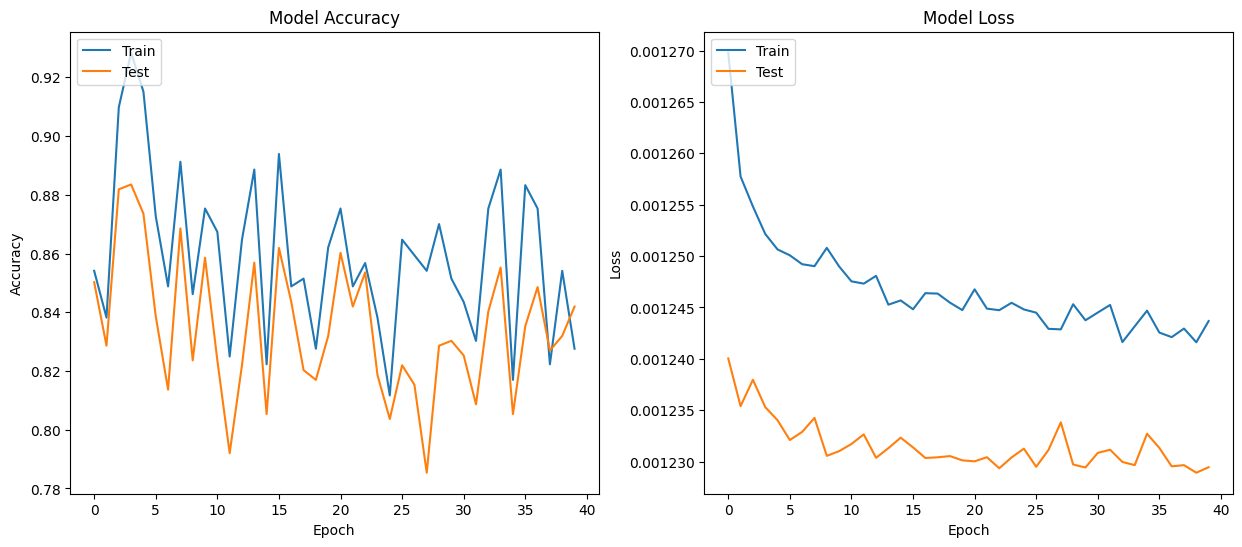

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Especifica el tamaño de la figura (ancho, alto)

plt.plot(losses_train)
plt.plot(losses_test)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


## Evaluación del modelo

Evaluamos diferentes métricas para el modelo con los datos de validación



In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

# Inicializar la tabla
table = PrettyTable()

# Definir las columnas
table.field_names = ['Conjunto', 'Accuracy', 'Recall', 'Especificidad', 'Precision', 'F1 Score', 'ROC AUC']

for name, X, Y in [('Entrenamiento', train_x, train_y), ('Prueba', val_x, val_y)]:
    model.eval()
    with torch.no_grad():
        test_inputs = torch.from_numpy(X.values).to(DEVICE).float().to(DEVICE)
        test_labels = torch.from_numpy(Y.values.reshape(-1, 1)).float().to(DEVICE)
        
        test_outputs = torch.sigmoid(model(test_inputs))
        test_preds = (test_outputs > umbral).float()
    
    test_preds_cpu = test_preds.cpu()
    test_labels_cpu = test_labels.cpu()
    test_outputs_cpu = test_outputs.cpu()
    
    accuracy = accuracy_score(test_labels_cpu, test_preds_cpu)
    precision = precision_score(test_labels_cpu, test_preds_cpu)
    sensitivity = recall_score(test_labels_cpu, test_preds_cpu, pos_label=1)
    f1 = f1_score(test_labels_cpu, test_preds_cpu)

    tn, fp, fn, tp = confusion_matrix(test_labels_cpu, test_preds_cpu).ravel()
    specificity = tn / (tn + fp)
    
    fpr, tpr, _ = roc_curve(test_labels_cpu, test_outputs_cpu)
    roc_auc = auc(fpr, tpr)
    
    table.add_row([name, round(accuracy, 3), round(sensitivity, 3), round(specificity, 3), round(precision, 3), round(f1, 3), round(roc_auc, 3)])

# Imprimir la tabla
print(table)


+---------------+----------+--------+---------------+-----------+----------+---------+
|    Conjunto   | Accuracy | Recall | Especificidad | Precision | F1 Score | ROC AUC |
+---------------+----------+--------+---------------+-----------+----------+---------+
| Entrenamiento |  0.864   |  0.33  |     0.891     |   0.133   |   0.19   |   0.68  |
|     Prueba    |  0.862   | 0.319  |     0.889     |   0.126   |  0.181   |  0.678  |
+---------------+----------+--------+---------------+-----------+----------+---------+


Construimos una matriz de confusión bonita, para ver los aciertos y errores del las predicciones del modelo. 

In [ ]:
#!pip install prettytable
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix

# Copiar los tensores de vuelta a la CPU
test_labels_cpu = test_labels.cpu()
test_preds_cpu = test_preds.cpu()

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(test_labels_cpu, test_preds_cpu)

# Crear la tabla
table = PrettyTable()
table.field_names = ["", "Predicción 0", "Predicción 1"]
table.add_row(["Valor Real 0", conf_matrix[0][0], conf_matrix[0][1]])
table.add_row(["Valor Real 1", conf_matrix[1][0], conf_matrix[1][1]])

# Imprimir la tabla
print("Matriz de Confusión:")
print(table)

Matriz de Confusión:
+--------------+--------------+--------------+
|              | Predicción 0 | Predicción 1 |
+--------------+--------------+--------------+
| Valor Real 0 |    48132     |     5982     |
| Valor Real 1 |     1843     |     864      |
+--------------+--------------+--------------+


Construimos la curva roc, entre mas cercana a 1 mejor, y entre mas cercana a la linea de referencia del centro (roc auc de 0.5) el modelo presenta mayor limitación. 

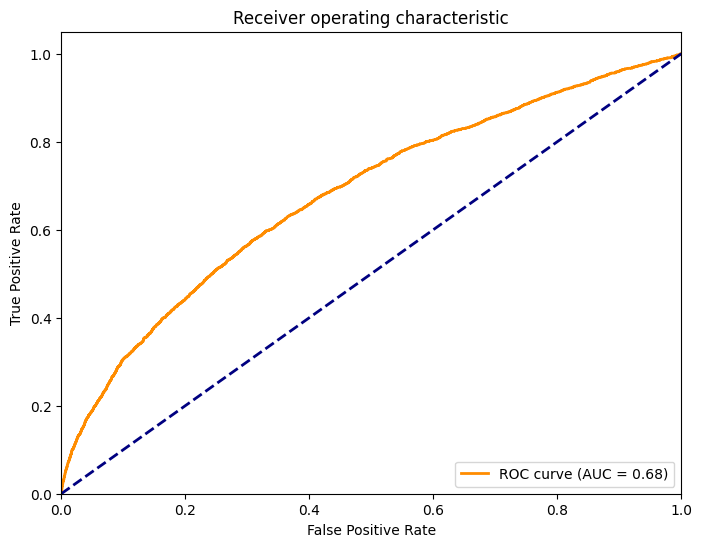

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Copiar los tensores de vuelta a la CPU
test_labels_cpu = test_labels.cpu()
test_outputs_cpu = test_outputs.cpu()

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr, tpr, _ = roc_curve(test_labels_cpu, test_outputs_cpu)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Escogencia del umbral de clasificación de la probabilidad

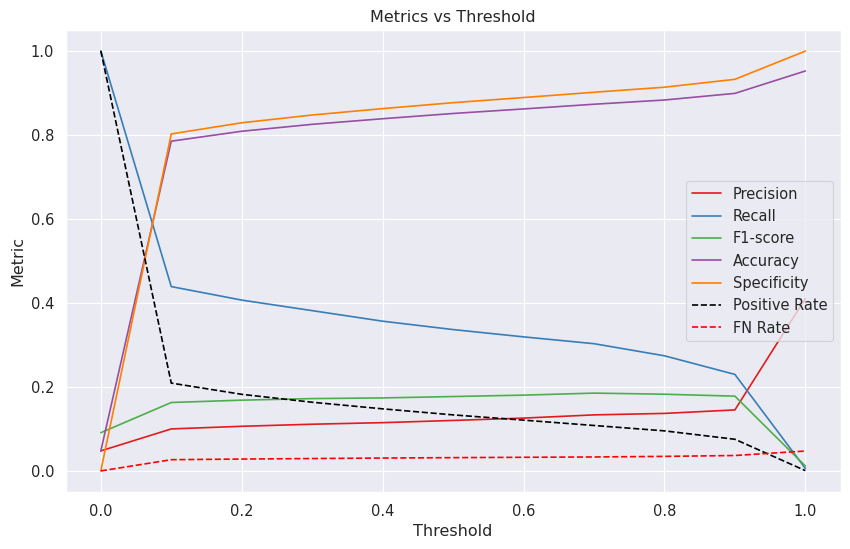

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# obtiene las probabilidades de predicción del modelo
model.eval()
with torch.no_grad():
    y_prob = torch.sigmoid(model(test_inputs))

# define los umbrales a evaluar
thresholds = np.arange(0, 1.1, 0.1)

# inicializa las listas de las métricas
accuracies = []
precisions = []
recalls = []
f1_scores = []
specificities = []
positive_rates = []
falsenegative_rates = []


# evalúa las métricas para cada umbral
for threshold in thresholds:
    # convierte las probabilidades a predicciones binarias utilizando el umbral
    y_pred = (y_prob >= threshold).cpu().numpy().astype(int)
    
    # calcula y almacena las métricas de evaluación
    accuracies.append(accuracy_score(test_labels_cpu, y_pred))
    precisions.append(precision_score(test_labels_cpu, y_pred))
    recalls.append(recall_score(test_labels_cpu, y_pred))
    f1_scores.append(f1_score(test_labels_cpu, y_pred))

    # calcula la matriz de confusión y extrae los valores de TN y FP
    tn, fp, fn, tp = confusion_matrix(test_labels_cpu, y_pred).ravel()
    
    # calcula y almacena la especificidad
    specificity = tn / (tn + fp)
    specificities.append(specificity)

    # calcula la relación (TP + FP) / (TP + FP + TN + FN)
    positive_rate = (tp + fp) / (tn + fp + fn + tp)
    positive_rates.append(positive_rate)

    # calcula la relación (TP + FP) / (TP + FP + TN + FN)
    falsenegative_rate = (fn) / (tn + fp + fn + tp)
    falsenegative_rates.append(falsenegative_rate)

# Configuración de Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.set_context("paper", font_scale=1.2)

# Personalizar colores
colors = sns.color_palette("Set1", n_colors=5)

# grafica las métricas en función del umbral
plt.plot(thresholds, precisions, label='Precision', color=colors[0])
plt.plot(thresholds, recalls, label='Recall', color=colors[1])
plt.plot(thresholds, f1_scores, label='F1-score', color=colors[2])
plt.plot(thresholds, accuracies, label='Accuracy', color=colors[3])
plt.plot(thresholds, specificities, label='Specificity', color=colors[4])
plt.plot(thresholds, positive_rates, '--', color='black', label='Positive Rate')
plt.plot(thresholds, falsenegative_rates, '--', color='red', label='FN Rate')

# Añadir leyendas, título y etiquetas de los ejes
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Metrics vs Threshold')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# obtiene las probabilidades de predicción del modelo
model.eval()
with torch.no_grad():
    y_prob = torch.sigmoid(model(inputs_test))

# define los umbrales a evaluar
thresholds = np.arange(0, 1.0, 0.001)

# inicializa las listas de las métricas
accuracies = []
precisions = []
recalls = []
f1_scores = []
specificities = []
positive_rates = []
falsenegative_rates = []

# evalúa las métricas para cada umbral
for threshold in thresholds:
    # convierte las probabilidades a predicciones binarias utilizando el umbral
    y_pred = (y_prob >= threshold).cpu().numpy().astype(int)
    
    # calcula y almacena las métricas de evaluación
    accuracies.append(accuracy_score(test_labels_cpu, y_pred))
    precisions.append(precision_score(test_labels_cpu, y_pred))
    recalls.append(recall_score(test_labels_cpu, y_pred))
    f1_scores.append(f1_score(test_labels_cpu, y_pred))

    # calcula la matriz de confusión y extrae los valores de TN y FP
    tn, fp, fn, tp = confusion_matrix(test_labels_cpu, y_pred).ravel()
    
    # calcula y almacena la especificidad
    specificity = tn / (tn + fp)
    specificities.append(specificity)

    # calcula la relación (TP + FP) / (TP + FP + TN + FN)
    positive_rate = (tp + fp) / (tn + fp + fn + tp)
    positive_rates.append(positive_rate)

    # calcula la relación (TP + FP) / (TP + FP + TN + FN)
    falsenegative_rate = (fn) / (tn + fp + fn + tp)
    falsenegative_rates.append(falsenegative_rate)

# Crea un DataFrame con las métricas y los umbrales
datox = {
    'Threshold': thresholds,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'Accuracy': accuracies,
    'Specificity': specificities,
    'Positive Rate': positive_rates,
    'FN Rate': falsenegative_rates
}
df_umbral = pd.DataFrame(datox)

# Configuración de formato de la tabla
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Muestra la tabla resumen
print(df_umbral.to_string(index=False))


 Threshold  Precision   Recall  F1-Score  Accuracy  Specificity  Positive Rate  FN Rate
     0.000   0.047659 1.000000  0.090981  0.047659     0.000000       1.000000 0.000000
     0.001   0.073292 0.670113  0.132133  0.580470     0.575983       0.435745 0.015722
     0.002   0.076694 0.627031  0.136671  0.622461     0.622233       0.389647 0.017775
     0.003   0.078880 0.609060  0.139671  0.642407     0.644076       0.367988 0.018632
     0.004   0.080339 0.597243  0.141627  0.654973     0.657862       0.354296 0.019195
     0.005   0.081522 0.590103  0.143254  0.663608     0.667287       0.344980 0.019535
     0.006   0.082551 0.584195  0.144660  0.670754     0.675085       0.337272 0.019817
     0.007   0.083413 0.578287  0.145796  0.677054     0.681997       0.330408 0.020098
     0.008   0.084183 0.573117  0.146803  0.682510     0.687984       0.324459 0.020345
     0.009   0.084908 0.569670  0.147789  0.686886     0.692752       0.319755 0.020509
     0.010   0.085070 0.564746  

# Optimización bayesiana para la busqueda de la mejor arquitectura

Busqueda de mejor hiperparámetros con optimización bayesiana

In [ ]:
VERBOSE = False
EPOCAS = 5

In [ ]:
def train_and_evaluate_Accuracy_2layer(hidden_1,hidden_2,learning_rate, batch_size):
    
    # limpieza de modelos precedentes
    reset_seed()
    
    # Algunos hiperparámetros deben ser enteros. La optimización bayesiana no 
    # se encarga de eso, por lo que hay que convertirlos "a pie"
    hidden_1 = int(round(hidden_1))
    hidden_2 = int(round(hidden_2))
    batch_size = int(round(batch_size))

    print(f"Evaluando con arquitectura ({hidden_1}), Evaluando con arquitectura ({hidden_2}), con lr {learning_rate}",
          f"y batch_size {batch_size}.  ", end= "")
    
    epocas = EPOCAS
    # Ciclo de entrenamiento
    model, losses_train, accs_train, losses_val, accs_val, tiempo = train_model(
        train_batch_size=batch_size, 
        inter_dense1=hidden_1,
        inter_dense2=hidden_2,
        learning_rate=learning_rate,
        epocas=epocas,
        verbose=VERBOSE)
    train_loss, train_acc = losses_train[epocas-1], accs_train[epocas-1]
    val_loss, val_acc = losses_val[epocas-1], accs_val[epocas-1]

    val_loss = -1 * val_loss

    print(f"El accuracy de train/val son {train_acc:.3f}/{val_acc:.3f}, el loss train/val son {train_loss:.4f}/{val_loss:.4f}, tiempo: {tiempo:.2f} segundos".format(train_acc, val_acc))

    return val_loss

In [ ]:
train_and_evaluate_Accuracy_2layer(hidden_1=80, hidden_2=40, learning_rate=0.01, batch_size=1024)

Evaluando con arquitectura (80), Evaluando con arquitectura (40), con lr 0.01 y batch_size 1024.  El accuracy de train/val son 0.880/0.816, el loss train/val son 0.0013/-0.0012, tiempo: 0.45 segundos


-0.0012485029576266183

In [ ]:
#!pip install bayesian-optimization
#conda install -c conda-forge bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
pbounds = {'hidden_1': (1, 200), 'hidden_2': (1, 200), 'learning_rate': (0.001, 0.1), 'batch_size':(1024, 1024)} #lr (10-3,10+3)

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_Accuracy_2layer,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [ ]:
%%time 
optimizer.maximize(
    init_points=5,
    n_iter=10,
)

|   iter    |  target   | batch_... | hidden_1  | hidden_2  | learni... |
-------------------------------------------------------------------------
Evaluando con arquitectura (144), Evaluando con arquitectura (1), con lr 0.03093092469055214 y batch_size 1024.  El accuracy de train/val son 0.866/0.895, el loss train/val son 0.0013/-0.0012, tiempo: 0.40 segundos
| 1         | -0.001249 | 1.024e+03 | 144.3     | 1.023     | 0.03093   |
Evaluando con arquitectura (19), Evaluando con arquitectura (38), con lr 0.03521051197726173 y batch_size 1024.  El accuracy de train/val son 0.898/0.912, el loss train/val son 0.0013/-0.0013, tiempo: 0.39 segundos
| 2         | -0.001259 | 1.024e+03 | 19.38     | 38.07     | 0.03521   |
Evaluando con arquitectura (108), Evaluando con arquitectura (84), con lr 0.06883673053927919 y batch_size 1024.  El accuracy de train/val son 0.907/0.937, el loss train/val son 0.0013/-0.0013, tiempo: 0.40 segundos
| 3         | -0.001277 | 1.024e+03 | 108.2     | 84.42   

In [ ]:
VERBOSE=False

In [ ]:
%%time
optimizer.maximize(
    init_points=100,
    n_iter=20,
)

|   iter    |  target   | batch_... | hidden_1  | hidden_2  | learni... |
-------------------------------------------------------------------------
Evaluando con arquitectura (194), Evaluando con arquitectura (63), con lr 0.06953993895126209 y batch_size 2412.  El accuracy de train/val son 0.880/0.862, el loss train/val son 0.0005/-0.0005, tiempo: 1684078299.40 segundos
| 16        | -0.000531 | 2.412e+03 | 193.7     | 63.37     | 0.06954   |
Evaluando con arquitectura (179), Evaluando con arquitectura (18), con lr 0.0048664235400553545 y batch_size 2635.  El accuracy de train/val son 0.862/0.909, el loss train/val son 0.0005/-0.0005, tiempo: 1684078301.04 segundos
| 17        | -0.000487 | 2.635e+03 | 179.0     | 17.92     | 0.004866  |
Evaluando con arquitectura (176), Evaluando con arquitectura (21), con lr 0.042689654875500166 y batch_size 551.  El accuracy de train/val son 0.858/0.885, el loss train/val son 0.0023/-0.0023, tiempo: 1684078300.06 segundos
| 18        | -0.002346 | 5

In [ ]:
optimizer.max

{'target': -0.00043039376082956065,
 'params': {'batch_size': 2994.729159891141,
  'hidden_1': 194.01842928399412,
  'hidden_2': 17.811654196407023,
  'learning_rate': 0.07721590287722724}}

In [ ]:
pbounds = {'hidden_1': (100, 250), 'hidden_2': (1, 50), 'learning_rate': (0.05, 0.9), 'batch_size':(3000, 10000)}
optimizer.set_bounds(pbounds)

In [ ]:
optimizer.maximize(
    init_points=5, #Epocas con la configuración de parametros
    n_iter=50, #Configuracion de parametros
)

|   iter    |  target   | batch_... | hidden_1  | hidden_2  | learni... |
-------------------------------------------------------------------------
Evaluando con arquitectura (112), Evaluando con arquitectura (2), con lr 0.106716247993453 y batch_size 4004.  El accuracy de train/val son 0.875/0.837, el loss train/val son 0.0003/-0.0003, tiempo: 1684078298.05 segundos
| 136       | -0.000321 | 4.004e+03 | 111.8     | 1.898     | 0.1067    |
Evaluando con arquitectura (117), Evaluando con arquitectura (2), con lr 0.6916322591818973 y batch_size 6210.  El accuracy de train/val son 0.889/0.861, el loss train/val son 0.0002/-0.0002, tiempo: 1684078298.11 segundos
| 137       | -0.000206 | 6.21e+03  | 117.0     | 2.361     | 0.6916    |
Evaluando con arquitectura (212), Evaluando con arquitectura (23), con lr 0.43257373495064694 y batch_size 5764.  El accuracy de train/val son 0.952/0.959, el loss train/val son 0.0002/-0.0002, tiempo: 1684078299.51 segundos
| 138       | -0.000233 | 5.764e+0

In [ ]:
optimizer.max

{'target': -0.008995979272862985,
 'params': {'batch_size': 766.4989014306193,
  'hidden_1': 251.0215975437898,
  'learning_rate': 0.011749752052049553}}

In [ ]:
# limpieza de modelos precedentes
reset_seed()
    
epocas=100
hidden_1 = 115
hidden_2 = 30
batch_size = 1024
learning_rate = 0.01
   
#model, losses_train, accs_train, losses_test, accs_test, tiempo = train_model(
#    train_batch_size=1024, inter_dense1 = 115, inter_dense2 = 30, learning_rate = 0.02, epocas=40, device=DEVICE, verbose=True, patience=10)

# Data loader con el batch size de entrenamiento modificado
train_loader = torch.utils.data.DataLoader(trainloader, batch_size=batch_size, shuffle=True, num_workers=2)

# Ciclo de entrenamiento
model, losses_train, accs_train, losses_val, accs_val, tiempo = train_model(
    train_batch_size=batch_size, inter_dense1=hidden_1, inter_dense2 = hidden_2, learning_rate=learning_rate, epocas=epocas, verbose=True)

train_loss, train_acc = losses_train[epocas-1], accs_train[epocas-1]
val_loss, val_acc = losses_val[epocas-1], accs_val[epocas-1]

0: loss train: 0.001612, accuracy train: 0.733690, loss val: 0.009239, accuracy val: 0.644374, -- epoch time: 9.54
1: loss train: 0.001548, accuracy train: 0.754164, loss val: 0.009033, accuracy val: 0.783556, -- epoch time: 9.42
2: loss train: 0.001529, accuracy train: 0.766190, loss val: 0.009110, accuracy val: 0.761589, -- epoch time: 5.29
3: loss train: 0.001524, accuracy train: 0.777250, loss val: 0.009300, accuracy val: 0.742468, -- epoch time: 4.01
4: loss train: 0.001513, accuracy train: 0.774685, loss val: 0.009164, accuracy val: 0.807683, -- epoch time: 4.79
5: loss train: 0.001506, accuracy train: 0.780261, loss val: 0.009032, accuracy val: 0.793458, -- epoch time: 4.65
6: loss train: 0.001501, accuracy train: 0.784439, loss val: 0.009070, accuracy val: 0.806781, -- epoch time: 4.14
7: loss train: 0.001495, accuracy train: 0.781927, loss val: 0.009111, accuracy val: 0.807170, -- epoch time: 4.63
8: loss train: 0.001491, accuracy train: 0.792141, loss val: 0.009124, accuracy 

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot([t.cpu().numpy() for t in accs_train])  # Convierte cada tensor en un array de NumPy
ax.plot([t.cpu().numpy() for t in accs_val])  # Convierte cada tensor en un array de NumPy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

ax = fig.add_subplot(1, 2, 2)
ax.plot(losses_train)  # No es necesario llamar a .cpu() ni a .numpy()
ax.plot(losses_val)  # No es necesario llamar a .cpu() ni a .numpy()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

_ = plt.show()


# T-SNE

In [ ]:
w = list(model.parameters())
embed_dict = {col: (categ_cols_mapping[col][0], w[i].detach().cpu().numpy()) for i, col in enumerate(categ_cols)}

In [ ]:
def plot_embed(embed_dict, col, perplexity = 2, n = 2 ):
    """
    Función que genera una visualización en menor dimensionalidad de un embedding
    Input:
    embed_dict (diccionario): Diccionario de embeddings
    col (string): Nombre de variable categórica
    perplexity (float): Parámetro utilizado por el TSNE para calcular la 
    representación.
    n (int): Dimensionalidad de la representación resultante de TSNE.
    """
    # Primero instanciamos TSNE
    tsne = TSNE(n_components = n, init='pca', random_state=43, 
          method='exact', perplexity=perplexity)
    # Ajustamos a nuestro embedding original obteniendo la representacion TSNE.
    X_embed = tsne.fit_transform(embed_dict[col][1])

    # Creamos un objeto para visualizar la representación TSNE.
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    # Graficamos la representación (data)
    ax.scatter(X_embed[:,0], X_embed[:,1])
    ax.set_title('TSNE - ' + col) # titulo

    # Etiquetamos cada punto para mayor claridad
    texts = [ax.text(X_embed[i,0], X_embed[i,1], txt) for i, 
       txt in enumerate(embed_dict[col][0])]

    # Utilizamos la función adjust_text para mejor distinción de cada etiqueta
    adjust_text(texts)

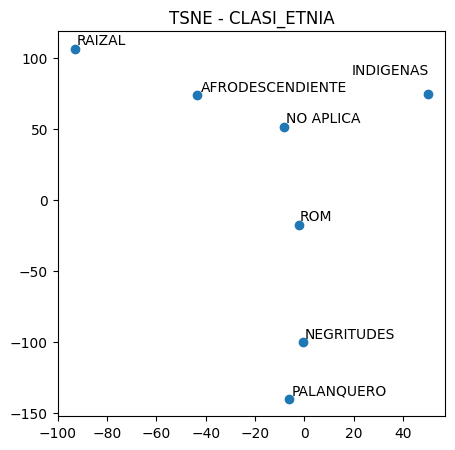

In [ ]:
plot_embed(embed_dict = embed_dict, col= 'CLASI_ETNIA',  perplexity = 2)

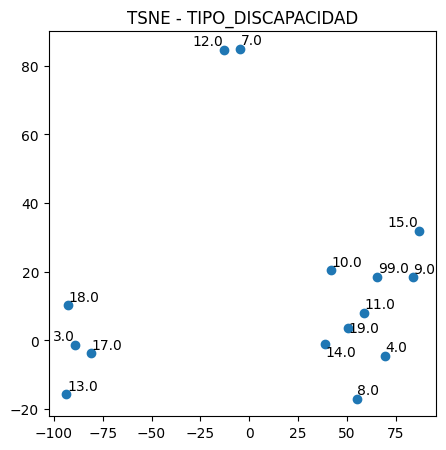

In [ ]:
plot_embed(embed_dict = embed_dict, col= 'TIPO_DISCAPACIDAD',  perplexity = 2)

In [ ]:
plot_embed(embed_dict = embed_dict, col= 'RES_MUN',  perplexity = 2)